### SatelliteBench

* [Dataset](https://physionet.org/content/multimodal-satellite-data/1.0.0/)

* [Paper](https://arxiv.org/abs/2401.11114)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import process_labels, split_data
from src.classifiers_base import preprocess_df

from transformers import BertTokenizer

from src.multimodal_data_loader import VQADataset
from torch.utils.data import DataLoader

from src.classifiers_base import train_early_fusion, train_late_fusion

In [2]:
PATH = 'datasets/satellitedata/'

In [3]:
text_path = os.path.join(PATH, 'labels.csv')
images_path = os.path.join(PATH, 'images')

## Get data

In [4]:
df = pd.read_csv(text_path)
df.Labels = df.Labels.astype(str)
df

,image_id,text,Labels,split,Labels_4,Labels_3
0,73001_2016-06-12.jpg,An image from city Ibagué taken in date 2016-0...,1,train,3,2
1,76001_2017-06-11.jpg,An image from city Cali taken in date 2017-06-...,1,train,1,1
2,8001_2018-04-15.jpg,An image from city Barranquilla taken in date ...,0,train,1,0
3,23001_2016-05-08.jpg,An image from city Montería taken in date 2016...,0,train,1,1
4,5001_2017-04-30.jpg,An image from city Medellín taken in date 2017...,0,train,1,0
...,...,...,...,...,...,...
1555,50001_2017-03-19.jpg,An image from city Villavicencio taken in date...,0,test,1,0
1556,23001_2017-03-26.jpg,An image from city Montería taken in date 2017...,0,test,0,0
1557,8001_2017-01-22.jpg,An image from city Barranquilla taken in date ...,0,test,0,0
1558,76001_2017-09-10.jpg,An image from city Cali taken in date 2017-09-...,0,test,0,0


## Data Perparation

In [5]:
# Select features and labels vectors
text_columns = 'text'
image_columns = 'image_id'
label_columns = 'Labels'

df = preprocess_df(df, image_columns, images_path)

# Split the data
train_df, test_df = split_data(df)

# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)

100%|██████████| 1560/1560 [00:00<00:00, 3400.30it/s]


Train Shape: (936, 6)
Test Shape: (312, 6)


In [6]:
train_df

,image_id,text,Labels,split,Labels_4,Labels_3
0,datasets/satellitedata/images/73001_2016-06-12...,An image from city Ibagué taken in date 2016-0...,1,train,3,2
1,datasets/satellitedata/images/76001_2017-06-11...,An image from city Cali taken in date 2017-06-...,1,train,1,1
2,datasets/satellitedata/images/8001_2018-04-15.jpg,An image from city Barranquilla taken in date ...,0,train,1,0
3,datasets/satellitedata/images/23001_2016-05-08...,An image from city Montería taken in date 2016...,0,train,1,1
4,datasets/satellitedata/images/5001_2017-04-30.jpg,An image from city Medellín taken in date 2017...,0,train,1,0
...,...,...,...,...,...,...
931,datasets/satellitedata/images/23001_2016-03-06...,An image from city Montería taken in date 2016...,1,train,2,1
932,datasets/satellitedata/images/68001_2017-09-03...,An image from city Bucaramanga taken in date 2...,0,train,0,0
933,datasets/satellitedata/images/41001_2018-08-26...,An image from city Neiva taken in date 2018-08...,0,train,0,0
934,datasets/satellitedata/images/54001_2017-06-18...,An image from city Cúcuta taken in date 2017-0...,0,train,0,0


In [7]:
# Instantiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Models

In [9]:
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 197250
Epoch 1/30 - Test Accuracy: 0.4583, macro-f1: 0.4212
Epoch 1/30 - Training Time: 29.55 seconds | Inference Time: 9.59 seconds
Epoch 2/30 - Test Accuracy: 0.5192, macro-f1: 0.5127
Epoch 2/30 - Training Time: 28.42 seconds | Inference Time: 9.66 seconds
Epoch 3/30 - Test Accuracy: 0.5096, macro-f1: 0.5047
Epoch 3/30 - Training Time: 27.83 seconds | Inference Time: 9.72 seconds
Epoch 4/30 - Test Accuracy: 0.4840, macro-f1: 0.4574
Epoch 4/30 - Training Time: 28.89 seconds | Inference Time: 9.69 seconds
Epoch 5/30 - Test Accuracy: 0.4968, macro-f1: 0.4904
Epoch 5/30 - Training Time: 28.68 seconds | Inference Time: 9.46 seconds
Epoch 6/30 - Test Accuracy: 0.5385, macro-f1: 0.5384
Epoch 6/30 - Training Time: 28.51 seconds | Inference Time: 9.51 seconds
Epoch 7/30 - Test Accuracy: 0.5256, macro-f1: 0.5110
Epoch 7/30 - Training Time: 28.53 seconds | Inference Time: 9.75 seconds
Epoch 8/30 - Test Accuracy: 0.5224, mac

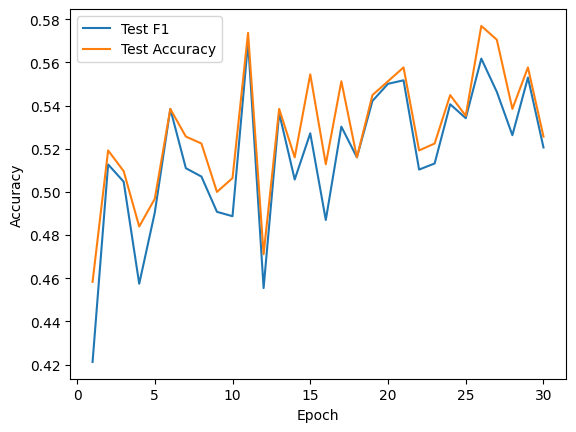

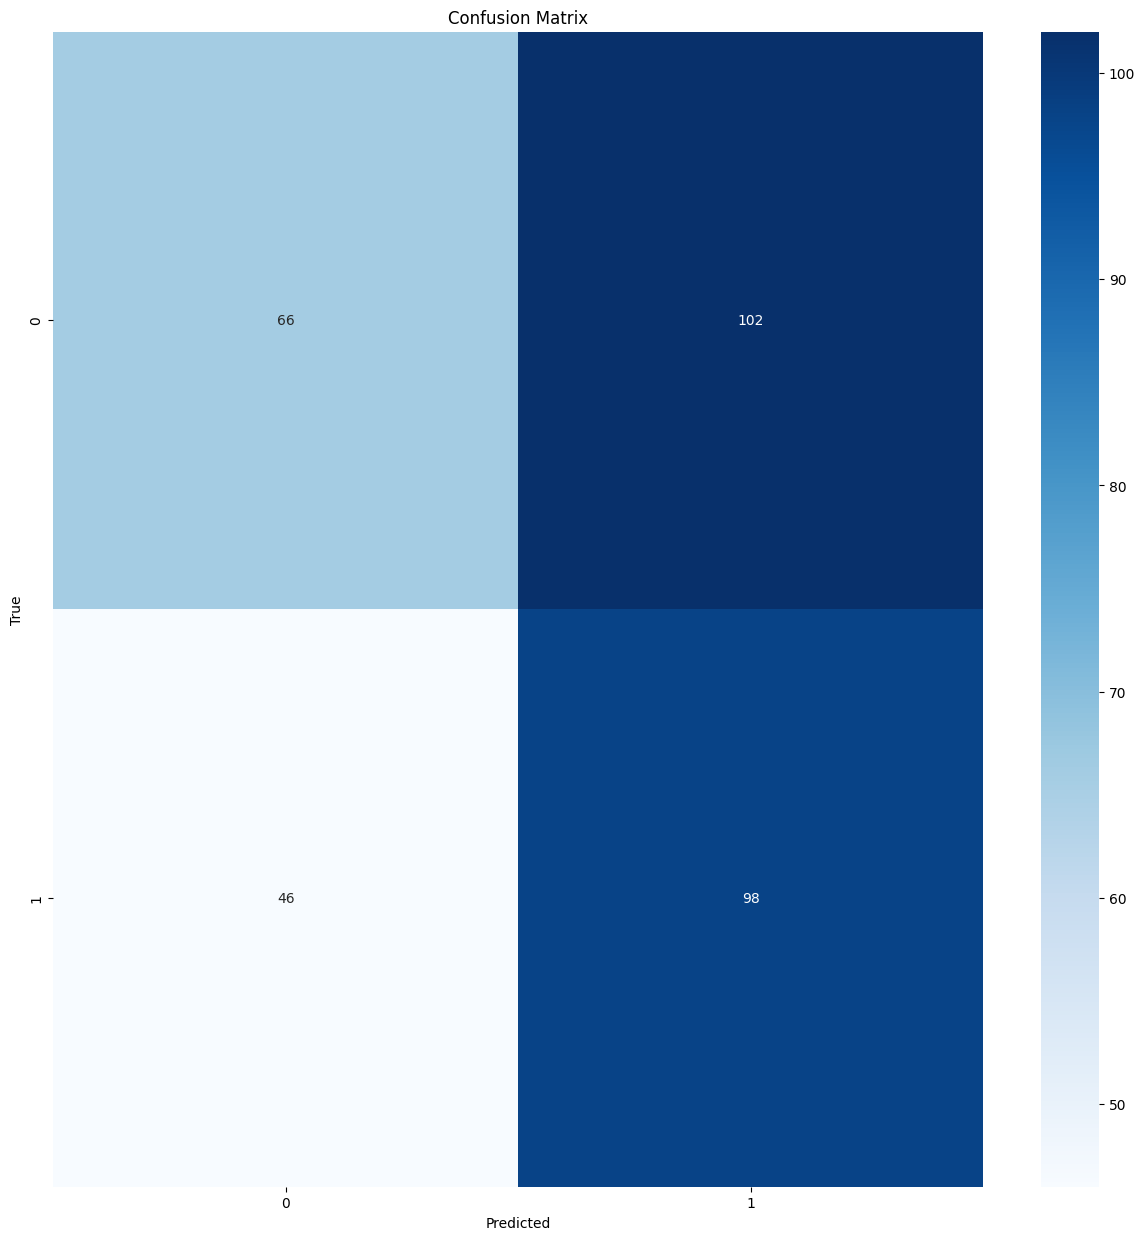

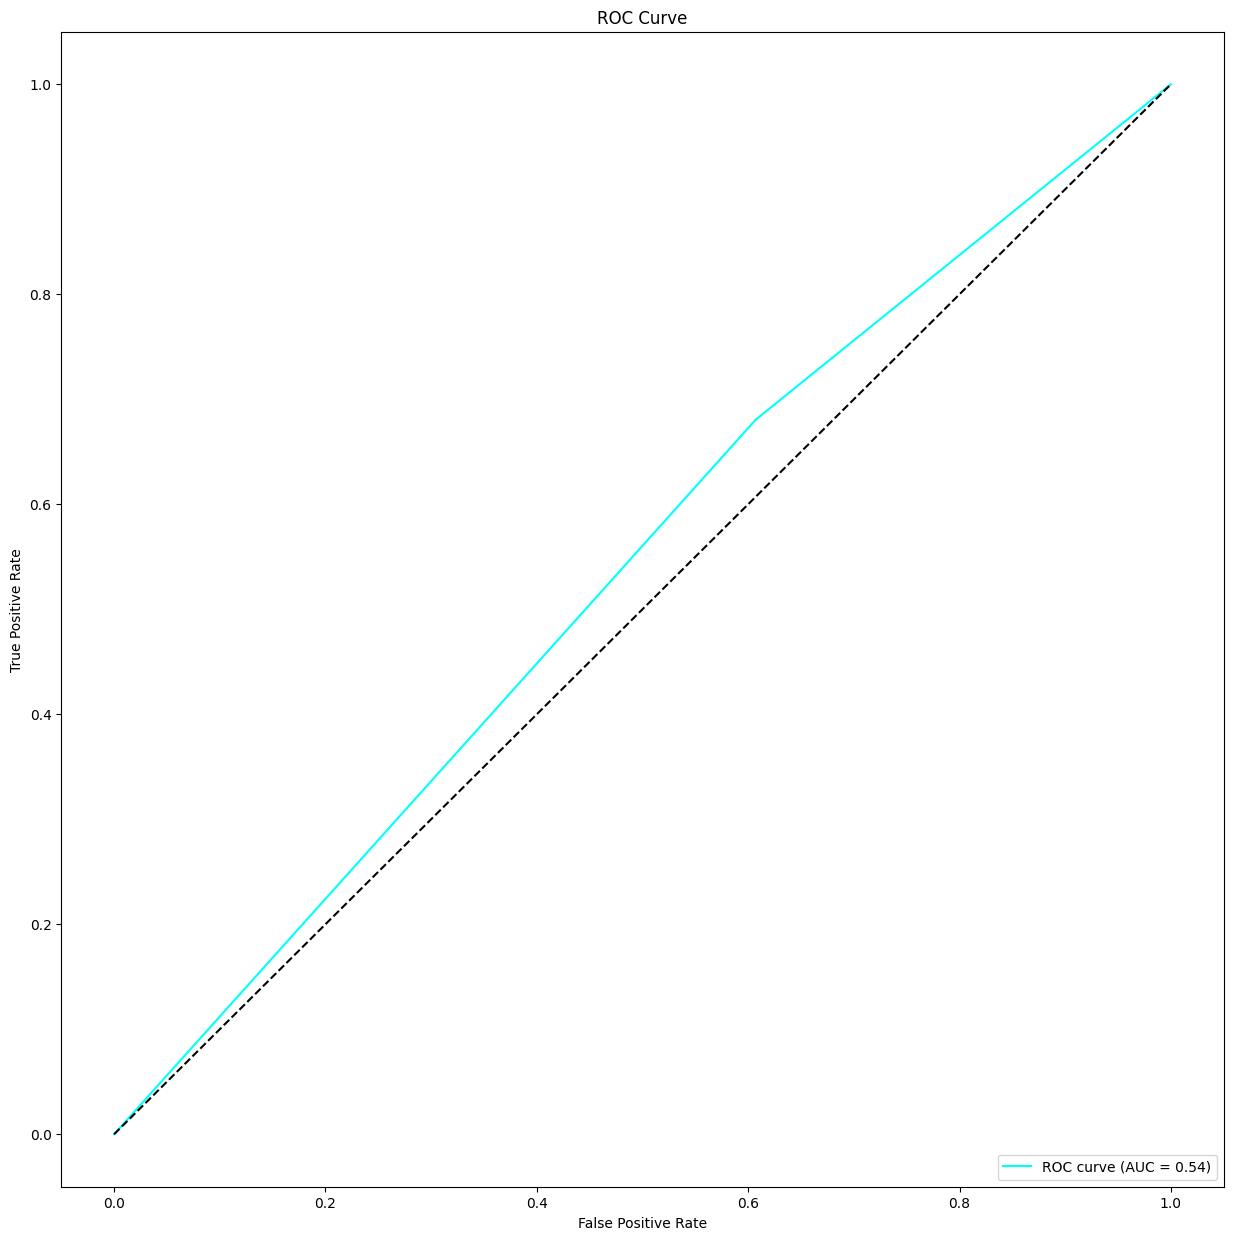

              precision    recall  f1-score   support

           0       0.59      0.39      0.47       168
           1       0.49      0.68      0.57       144

    accuracy                           0.53       312
   macro avg       0.54      0.54      0.52       312
weighted avg       0.54      0.53      0.52       312



In [10]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, lr=0.001, freeze_backbone=True)

Training Late Fusion Model:
The number of parameters of the model are: 98946
Epoch 1/30 - Test Accuracy: 0.4808, macro-f1: 0.4692
Epoch 1/30 - Training Time: 29.48 seconds | Inference Time: 9.45 seconds
Epoch 2/30 - Test Accuracy: 0.5321, macro-f1: 0.5187
Epoch 2/30 - Training Time: 28.21 seconds | Inference Time: 9.55 seconds
Epoch 3/30 - Test Accuracy: 0.5128, macro-f1: 0.4785
Epoch 3/30 - Training Time: 28.86 seconds | Inference Time: 9.65 seconds
Epoch 4/30 - Test Accuracy: 0.5224, macro-f1: 0.4759
Epoch 4/30 - Training Time: 29.32 seconds | Inference Time: 9.54 seconds
Epoch 5/30 - Test Accuracy: 0.5096, macro-f1: 0.5064
Epoch 5/30 - Training Time: 29.04 seconds | Inference Time: 9.74 seconds
Epoch 6/30 - Test Accuracy: 0.5032, macro-f1: 0.4961
Epoch 6/30 - Training Time: 29.23 seconds | Inference Time: 10.00 seconds
Epoch 7/30 - Test Accuracy: 0.5385, macro-f1: 0.5347
Epoch 7/30 - Training Time: 28.86 seconds | Inference Time: 9.65 seconds
Epoch 8/30 - Test Accuracy: 0.5673, macr

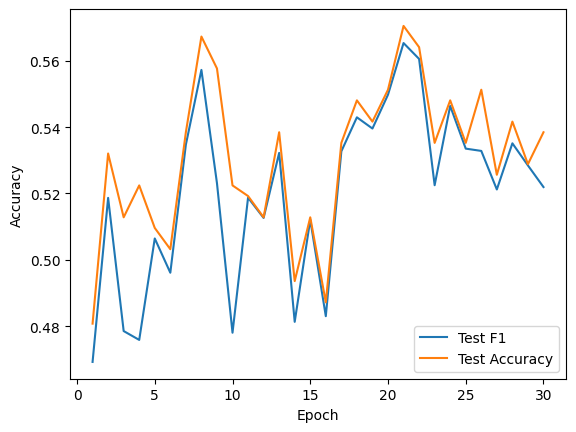

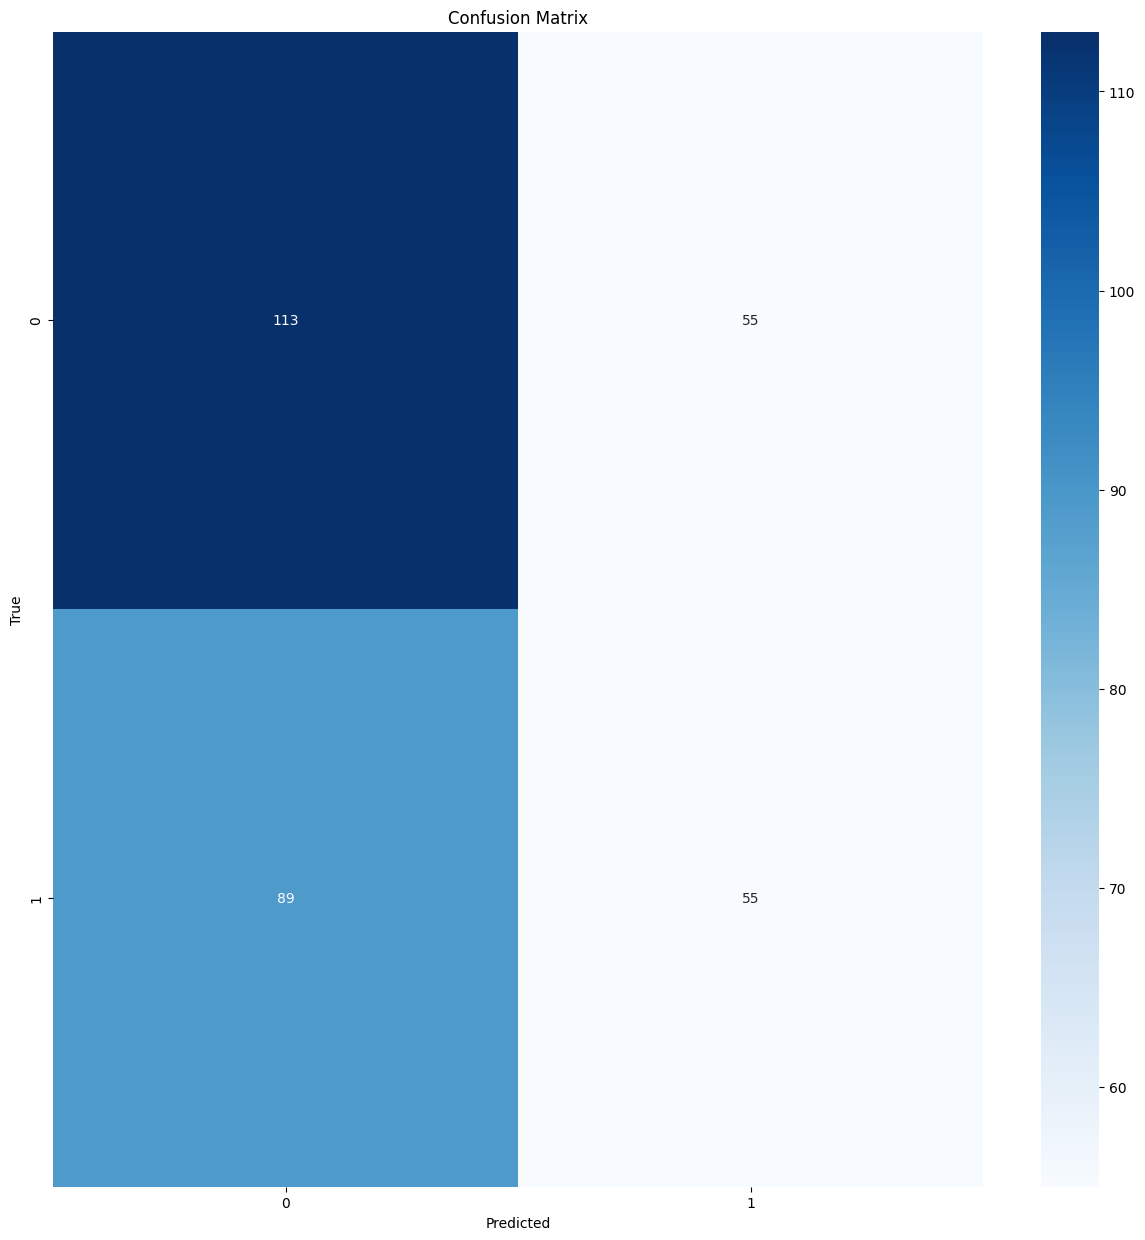

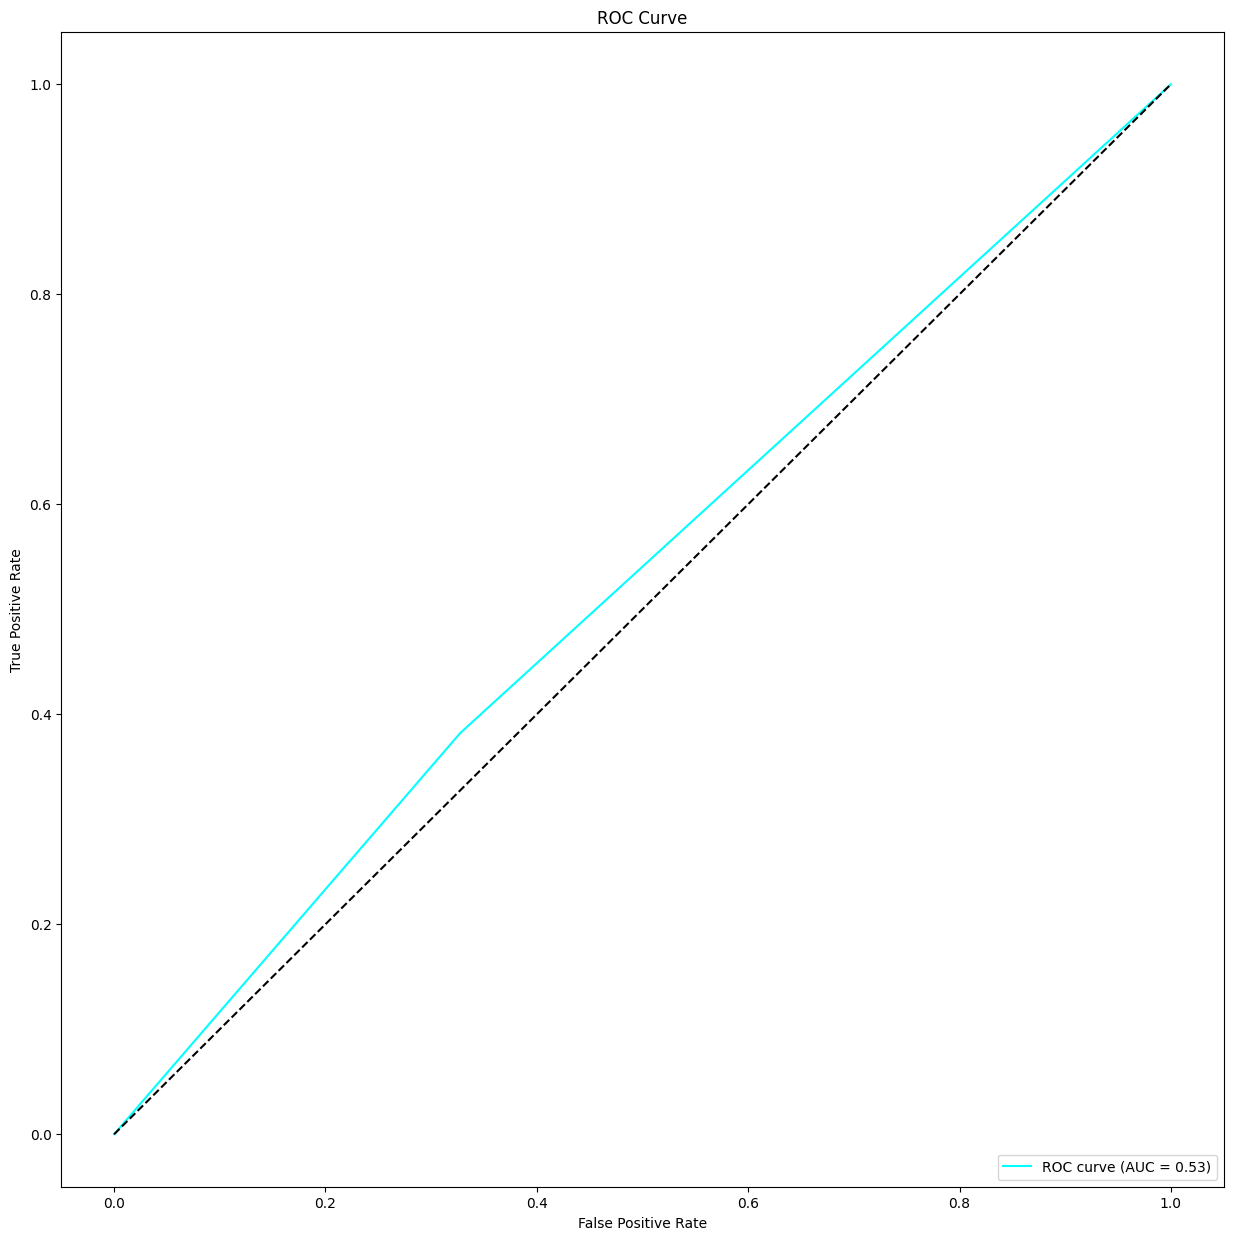

              precision    recall  f1-score   support

           0       0.56      0.67      0.61       168
           1       0.50      0.38      0.43       144

    accuracy                           0.54       312
   macro avg       0.53      0.53      0.52       312
weighted avg       0.53      0.54      0.53       312



In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, output_size, num_epochs=30, multilabel=multilabel, report=True, freeze_backbone=True)